## Data Preparation Notebook

To make the experience consistent, we will use [this link](https://huggingface.co/datasets/Sanyam/MM-Demo) for getting access to our dataset. To credit, thanks to the author [here](https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full) for making it available. 

As thanks to original author-Please upvote the dataset version on Kaggle if you enjoy this course.

## Data Cleanup

### Removing Corrupt Images

We will start by cleaning up the dataset first and checking for any corrupt images. 

#### Variables and Paths

Let's first download the dataset and set our variables to point to it. 

Remember, this is something you will change, don't rush the shift+enter fingers yet! Please also set your hf-token in the line below

In [1]:
DATA = "./DATA/"
META_DATA = f"{DATA}images.csv/"
IMAGES = f"{DATA}images_compressed/"

hf_token = ""
model_name = "meta-llama/Llama-3.2-11b-Vision-Instruct"

#### All the imports

We import all the libraries here. 

- PIL: For handling images to be passed to our Llama model
- Huggingface Transformers: For running the model
- Concurrent Library: To clean up faster

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image as PIL_Image
from PIL import Image

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import multiprocessing


import torch
from transformers import MllamaForConditionalGeneration, MllamaProcessor


#### Clean Corrupt Images

This might take a few moments since we have 5000 images in our dataset.

In [5]:
def is_image_corrupt(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return False
    except (IOError, SyntaxError, Image.UnidentifiedImageError):
        return True

def find_corrupt_images(folder_path):
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    num_cores = multiprocessing.cpu_count()
    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        results = executor.map(is_image_corrupt, image_files)
    
    corrupt_images = [img for img, is_corrupt in zip(image_files, results) if is_corrupt]
    return corrupt_images


folder_path = IMAGES  # Replace with your folder path
corrupt_images = find_corrupt_images(folder_path)

print("Corrupt images:")
for img in corrupt_images:
    print(img)
print(f"Total corrupt images found: {len(corrupt_images)}")

Corrupt images:
./DATA/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg
./DATA/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg
./DATA/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
./DATA/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
./DATA/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
./DATA/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg
Total corrupt images found: 6


In [6]:
corrupt_images

['./DATA/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg',
 './DATA/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg',
 './DATA/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg',
 './DATA/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg',
 './DATA/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg',
 './DATA/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg']

Let's load in the Meta-Data of the images and remove the rows with the corrupt images

In [7]:
df = pd.read_csv("./DATA/images.csv")
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [8]:
corrupt_filenames = [os.path.splitext(os.path.basename(path))[0] for path in corrupt_images]

# Print out the corrupt filenames for verification
print("Corrupt filenames:")
print(corrupt_filenames)

Corrupt filenames:
['d028580f-9a98-4fb5-a6c9-5dc362ad3f09', '784d67d4-b95e-4abb-baf7-8024f18dc3c8', 'b72ed5cd-9f5f-49a7-b12e-63a078212a17', '1d0129a1-f29a-4a3f-b103-f651176183eb', 'c60e486d-10ed-4f64-abab-5bb698c736dd', '040d73b7-21b5-4cf2-84fc-e1a80231b202']


We can now "clean" up the dataframe by subtracting the corrupt images.

In [9]:
df_clean = df[~df['image'].isin(corrupt_filenames)]
# Print the number of rows removed
print(f"Number of rows removed: {len(df) - len(df_clean)}")

# Display the first few rows of the cleaned DataFrame
print(df_clean.head())

Number of rows removed: 5
                                  image  sender_id     label   kids
0  4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False
1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False
2  00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False


In [10]:
df_clean.to_csv('clean.csv', index=False)

## EDA

Let's start by double-checking any empty values

In [11]:
df = pd.read_csv("./clean.csv")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      5398 non-null   object
 1   sender_id  5398 non-null   int64 
 2   label      5398 non-null   object
 3   kids       5398 non-null   bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 131.9+ KB


In [13]:
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [14]:
# Step 4: Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
image        0
sender_id    0
label        0
kids         0
dtype: int64


#### Understanding the Label Distribution 

The existing dataset comes with multi-labels, let's take a look at all categories:

In [15]:
print("\nUnique labels:")
print(df['label'].nunique())
print("\n Label Distribution:")
print(df['label'].value_counts())


Unique labels:
20

 Label Distribution:
label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip             7
Name: count, dtype: int64


In [16]:
print("\nDistribution of kids vs. non-kids images:")
print(df['kids'].value_counts(normalize=True))


Distribution of kids vs. non-kids images:
kids
False    0.911819
True     0.088181
Name: proportion, dtype: float64


Let's take a look at the distribution skew to understand what's in our dataset:

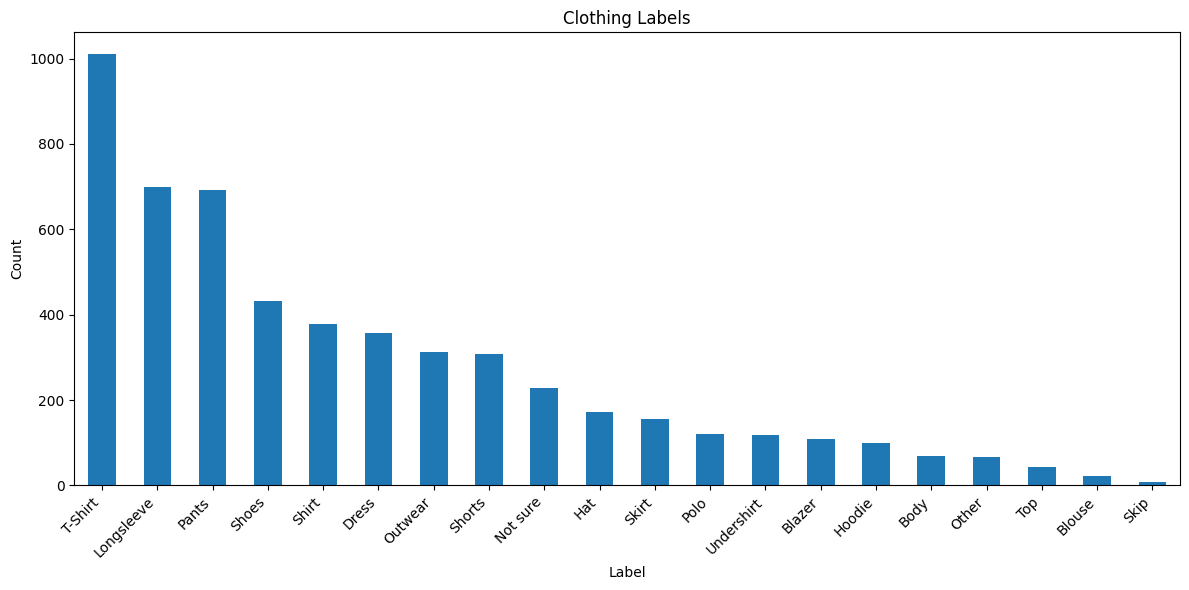

In [17]:
plt.figure(figsize=(12, 6))
df['label'].value_counts().head(20).plot(kind='bar')
plt.title('Clothing Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Let's start with some more cleanup:

- Remove kids clothing since that is a smaller subset
- Let's use our lack of understanding of fashion to reduce categories and also make our lives with pre-processing easier

In [18]:
df_no_kids = df[df['kids'] == False]
df_cleaned = df_no_kids.drop('kids', axis=1)

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_cleaned.shape}")

Original dataset shape: (5398, 4)
Cleaned dataset shape: (4922, 3)


In [19]:
df = df_cleaned
df

,image,sender_id,label
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes
...,...,...,...
5391,9bdac063-6c07-4bfc-a04a-e45224c503df,204,Undershirt
5393,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts
5395,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts
5396,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes


For once, lack of fashion knowledge is useful-we can reduce our work by creating less categories.

In [20]:
category_mapping = {
    'T-Shirt': 'T-Shirt',
    'Shoes': 'Shoes',
    'Top': 'Tops',
    'Blouse': 'Tops',
    'Shirt': 'Tops',
    'Polo': 'Tops',
    'Longsleeve': 'Tops',
    'Pants': 'Pants',
    'Jeans': 'Jeans',
    'Shorts': 'Shorts',
    'Skirt': 'Skirts',
    'Dress': 'Skirts',
    'Footwear': 'Shoes',
    'Outwear': 'Tops',
    'Hat': 'Tops',
    'Undershirt': 'T-Shirt',
    'Body': 'Tops',
    'Hoodie': 'Tops',
    'Blazer': 'Tops'
}

df_cleaned['merged_category'] = df_cleaned['label'].map(category_mapping).fillna('Other')

# Print the unique categories after merging
print("Unique categories after merging:")
print(df_cleaned['merged_category'].unique())

Unique categories after merging:
['Other' 'T-Shirt' 'Shoes' 'Shorts' 'Tops' 'Pants' 'Skirts']


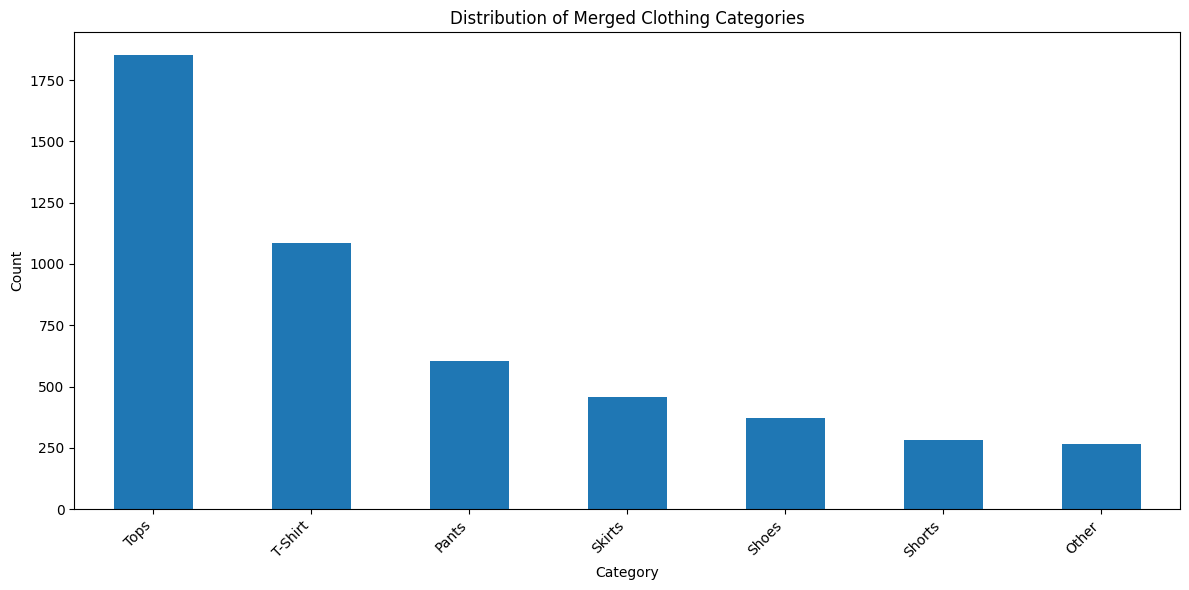

In [21]:
plt.figure(figsize=(12, 6))
df_cleaned['merged_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Merged Clothing Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This is the part that makes Thanos happy, we will balance our universe of clothes by randomly sampling.

In [22]:
def balance_category(group):
    if len(group) > 500:
        return group.sample(n=500, random_state=42)
    return group


df_balanced = df_cleaned.groupby('merged_category').apply(balance_category).reset_index(drop=True)

# Print the count of each category in the balanced dataset
print("\nCategory counts in the balanced dataset:")
print(df_balanced['merged_category'].value_counts())


Category counts in the balanced dataset:
merged_category
Pants      500
T-Shirt    500
Tops       500
Skirts     457
Shoes      371
Shorts     284
Other      266
Name: count, dtype: int64


/tmp/ipykernel_2065289/1389168415.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_cleaned.groupby('merged_category').apply(balance_category).reset_index(drop=True)


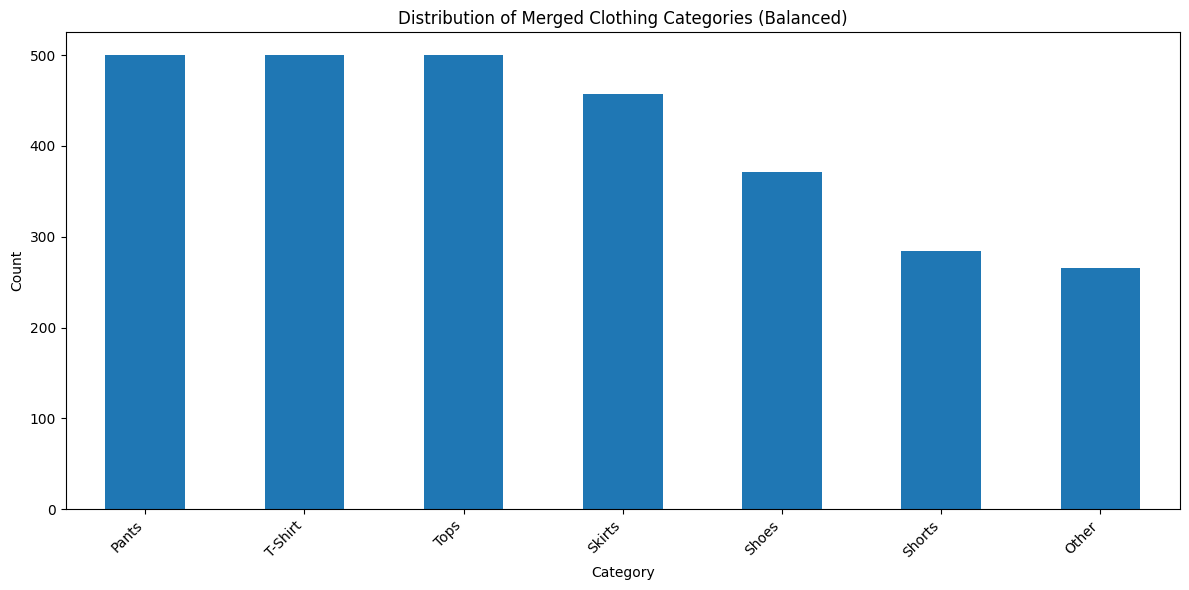

Balanced dataset shape: (2878, 4)
merged_category
Pants      500
T-Shirt    500
Tops       500
Skirts     457
Shoes      371
Shorts     284
Other      266
Name: count, dtype: int64


In [23]:
# Plot the distribution of the balanced dataset
plt.figure(figsize=(12, 6))
df_balanced['merged_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Merged Clothing Categories (Balanced)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Balanced dataset shape: {df_balanced.shape}")
print(df_balanced['merged_category'].value_counts())

In [24]:
# Save the balanced dataset
df_balanced.to_csv('balanced_dataset.csv', index=False)

## Synthetic Labelling using Llama 3.2

All the effort so far was to prepare our dataset for labelling. 

At this stage, we are ready to start labelling the images using Llama-3.2 models. We will use 11B here for testing. 

We suggest testing 90B as an assignment. Although you will find that 11B is a great candidate for this model. 

Read more about the model capabilities [here](https://www.llama.com/docs/how-to-guides/vision-capabilities/)

In [25]:
model = MllamaForConditionalGeneration.from_pretrained(model_name, device_map="auto", torch_dtype=torch.bfloat16, token=hf_token)
processor = MllamaProcessor.from_pretrained(model_name, token=hf_token)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
#!ls {IMAGES}

Feel free to randomly grab any example from the `ls` command above. This shirt is colorful enough for us to use-so we will go with the current example

In [27]:
image_path = f"{IMAGES}/01938e19-ece6-4f67-8e48-bfd6dd6ce399.jpg"

In [28]:
def get_image(image_path):
    with open(image_path, "rb") as f:
        return PIL_Image.open(f).convert("RGB")

image = get_image(image_path)

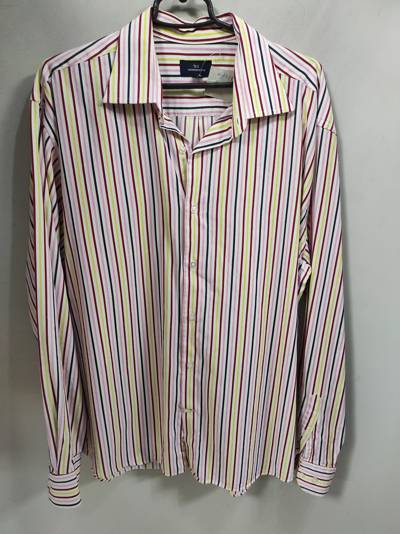

In [29]:
image

#### Labelling Prompt

We did a few sample runs to arrive on the prompt below: 

- Run a simple prompt on an image
- See output and iterate

After painfully trying this a few times, we learn that for some reason the model doesn't follow JSON formatting unless it's strongly urged. So we fix this with the dramatic prompt:

In [34]:
USER_TEXT_OPTION = """
You are an expert fashion captioner, we are writing descriptions of clothes, look at the image closely and write a caption for it.

Write the following Title, Size, Category, Gender, Type, Description in JSON FORMAT, PLEASE DO NOT FORGET JSON, 

ALSO START WITH THE JSON AND NOT ANY THING ELSE, FIRST CHAR IN YOUR RESPONSE IS ITS OPENING BRACE

FOLLOW THESE STEPS CLOSELY WHEN WRITING THE CAPTION: 
1. Only start your response with a dictionary like the example below, nothing else, I NEED TO PARSE IT LATER, SO DONT ADD ANYTHING ELSE-IT WILL BREAK MY CODE
Remember-DO NOT SAY ANYTHING ELSE ABOUT WHAT IS GOING ON, just the opening brace is the first thing in your response nothing else ok?
2. REMEMBER TO CLOSE THE DICTIONARY WITH '}'BRACE, IT GOES AFTER THE END OF DESCRIPTION-YOU ALWAYS FORGET IT, THIS WILL CAUSE A LOT OF ISSUES
3. If you cant tell the size from image, guess it! its okay but dont literally write that you guessed it
4. Do not make the caption very literal, all of these are product photos, DO NOT CAPTION HOW OR WHERE THEY ARE PLACED, FOCUS ON WRITING ABOUT THE PIECE OF CLOTHING
5. BE CREATIVE WITH THE DESCRIPTION BUT FOLLOW EVERYTHING CLOSELY FOR STRUCTURE
6. Return your answer in dictionary format, see the example below

{"Title": "Title of item of clothing", "Size": {'S', 'M', 'L', 'XL'}, #select one randomly if you cant tell from the image. DO NOT TELL ME YOU ESTIMATE OR GUESSED IT ONLY THE LETTER IS ENOUGH", Category":  {T-Shirt, Shoes, Tops, Pants, Jeans, Shorts, Skirts, Shoes, Footwear}, "Gender": {M, F, U}, "Type": {Casual, Formal, Work Casual, Lounge}, "Description": "Write it here"}

Example: ALWAYS RETURN ANSWERS IN THE DICTIONARY FORMAT BELOW OK?

{"Title": "Casual White pant with logo on it", "size": "L", "Category": "Jeans", "Gender": "U", "Type": "Work Casual", "Description": "Write it here, this is where your stuff goes"} 
"""

In [37]:
conversation = [
        {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": USER_TEXT}]}
    ]
prompt = processor.apply_chat_template(conversation, add_special_tokens=False, add_generation_prompt=True, tokenize=False)
inputs = processor(image, prompt, return_tensors="pt").to(model.device)
output = model.generate(**inputs, temperature=1, top_p=0.9, max_new_tokens=512)
processor.decode(output[0])[len(prompt):]

'end_header_id|>\n\n{"Title": "Striped Collared Shirt", "Size": "L", "Category": "Tops", "Gender": "F", "Type": "Casual", "Description": "This shirt features a classic design with thin vertical stripes in multiple colors, including red, blue, yellow, and green, giving it a fun and playful look. The collar and cuffs are both long, with the collar being open and unbuttoned, and the cuffs rolled up slightly. The buttons are small and round. The fabric appears to be lightweight, and the shirt appears to be slightly wrinkled, adding to its casual charm. The solid grey background of the image suggests a plain backdrop, and the dark shadows of the shirt hanging on a hanger indicate that it is a product photo. Overall, this shirt is perfect for a casual, everyday look, and its fun and playful pattern makes it a great addition to any wardrobe."}<|eot_id|>'

In [39]:
print(processor.decode(output[0])[len(prompt):])

end_header_id|>

{"Title": "Striped Collared Shirt", "Size": "L", "Category": "Tops", "Gender": "F", "Type": "Casual", "Description": "This shirt features a classic design with thin vertical stripes in multiple colors, including red, blue, yellow, and green, giving it a fun and playful look. The collar and cuffs are both long, with the collar being open and unbuttoned, and the cuffs rolled up slightly. The buttons are small and round. The fabric appears to be lightweight, and the shirt appears to be slightly wrinkled, adding to its casual charm. The solid grey background of the image suggests a plain backdrop, and the dark shadows of the shirt hanging on a hanger indicate that it is a product photo. Overall, this shirt is perfect for a casual, everyday look, and its fun and playful pattern makes it a great addition to any wardrobe."}<|eot_id|>


### Testing Labelling Script

The results from labelling above look promising, we can now start building a script skeleton in the notebook to test our label logic.

Let's test our approach for first 50 images after which we can let this run on multi-GPUs in a script. Remember, Llama-3.2 models can only look at one image at once.

In [43]:
hf_token = ""
model_name = "meta-llama/Llama-3.2-11b-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(model_name, device_map="auto", torch_dtype=torch.bfloat16, token=hf_token)
processor = MllamaProcessor.from_pretrained(model_name, token=hf_token)

# Define the input folder path
input_folder_path = IMAGES

# Define the output CSV file path
output_csv_file_path = "./captions_testing.csv"

# Create an empty list to store the results
results = []

# Loop through the first 50 files in the input folder
for filename in tqdm(os.listdir(input_folder_path)[:50], desc="Processing files"):
    # Check if the file is an image
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # Get the image path
        image_path = os.path.join(input_folder_path, filename)

        # Load the image
        image = get_image(image_path)

        # Create a conversation
        conversation = [
            {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": USER_TEXT}]}
        ]

        # Apply chat template and tokenize
        prompt = processor.apply_chat_template(conversation, add_special_tokens=False, add_generation_prompt=True, tokenize=False)
        inputs = processor(image, prompt, return_tensors="pt").to(model.device)

        # Generate the output
        output = model.generate(**inputs, temperature=1, top_p=0.9, max_new_tokens=512)

        # Decode the output
        decoded_output = processor.decode(output[0])[len(prompt):]

        # Append the result to the list
        results.append((filename, decoded_output))

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Processing files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:31<00:00,  4.23s/it]


In [44]:
import csv
# Write the results to a CSV file
with open(output_csv_file_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "description"])
    for result in results:
        writer.writerow(result)

It's always a great idea to validate LLM outputs, we can check our labels here:

In [48]:
df = pd.read_csv("./captions_testing.csv")
df

,filename,description
0,d7ed1d64-2c65-427f-9ae4-eb4aaa3e2389.jpg,"end_header_id|>\n\n**""A celestial-inspired des..."
1,5c1b7a77-1fa3-4af8-9722-cd38e45d89da.jpg,"end_header_id|>\n\n{""Title"": ""White Sweater"", ..."
2,b2e084c7-e3a0-4182-8671-b908544a7cf2.jpg,"end_header_id|>\n\n{""Title"": ""Simple Gray T-Sh..."
3,9d053b67-64e1-4050-a509-27332b9eca54.jpg,"end_header_id|>\n\n{ ""Title"": ""Summer Short Je..."
4,d885f493-1070-4d51-bd11-f1ec156a2aa7.jpg,end_header_id|>\n\nI cannot provide a response...
5,87846aa9-86cc-404a-af2c-7e8fe941081d.jpg,end_header_id|>\n\nI cannot provide a response...
6,22745622-ae32-407f-9af1-9a25eb79d7b3.jpg,"end_header_id|>\n\n{""Title"": ""Fitted Baby Cap""..."
7,04fa06fb-d71a-4293-9804-fe799375a682.jpg,end_header_id|>\n\nHere is the caption for the...
8,d9e84490-185d-48f9-ac16-4ef3360616d5.jpg,end_header_id|>\n\nHere is the description of ...
9,79e8d176-99e8-4f89-88f5-d26d957405a2.jpg,"end_header_id|>\n\n{""Title"": ""A t-shirt with a..."


In [46]:
#fin